In [2]:
import pandas as pd
import numpy as np
from imutils import paths
import torch
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import PIL
import cv2
sns.set_theme(context="notebook",style="darkgrid")

from sklearn.model_selection import train_test_split

import pytorch_lightning as pl
import timm
from torchvision import transforms

from torcheval.metrics.functional import multiclass_f1_score,multiclass_recall, multiclass_precision
from torchmetrics.classification import MulticlassAUROC
from sklearn.metrics import confusion_matrix,classification_report

# 1-) Leitura e Preprocessamento dos Dados

In [3]:
# Modificar essa leitura, deixar igual ao codigo de segmentation

path = "/kaggle/input/lungs-classification/lungs_classification"
folders = ['/train','/test']

train_paths = sorted(list(paths.list_images(path+folders[0])))
test_paths = sorted(list(paths.list_images(path+folders[1])))

all_paths = np.array(train_paths+test_paths)

In [4]:
# Lendo os metadados das imagens
metadata_df = pd.read_csv("/kaggle/input/lungs-classification/drive-download-20230204T134519Z-001/Chest_xray_Corona_Metadata.csv",usecols=np.arange(1,6,1))
display(metadata_df)

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...
5905,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [5]:
# Lendo o sumario de dados das imagens
summary_df = pd.read_csv("/kaggle/input/lungs-classification/drive-download-20230204T134519Z-001/Chest_xray_Corona_dataset_Summary.csv",usecols=np.arange(1,5,1))

summary_df.Label_1_Virus_category.replace(np.nan,'Normal',inplace=True)
summary_df.loc[summary_df.Label=='Normal','Label_2_Virus_category'] = 'Normal'
summary_df.loc[(summary_df.Label_1_Virus_category=='Virus') & (summary_df.Label_2_Virus_category.isna()),'Label_2_Virus_category'] = 'Virus-desconhecido'
summary_df.loc[(summary_df.Label_1_Virus_category=='bacteria') & (summary_df.Label_2_Virus_category.isna()),'Label_2_Virus_category'] = 'bacteria-desconhecido'

display(summary_df)

,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,Normal,Normal,Normal,1576
1,Pnemonia,Stress-Smoking,ARDS,2
2,Pnemonia,Virus,Virus-desconhecido,1493
3,Pnemonia,Virus,COVID-19,58
4,Pnemonia,Virus,SARS,4
5,Pnemonia,bacteria,bacteria-desconhecido,2772
6,Pnemonia,bacteria,Streptococcus,5


# 2-) EDA

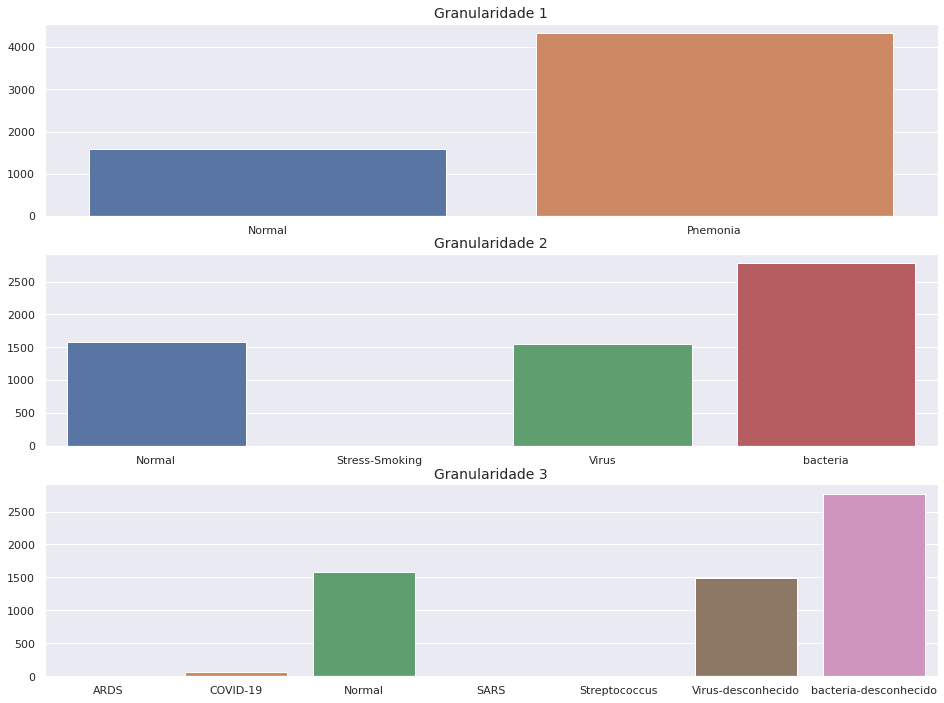

In [6]:
# Análise da distribuição dos labels, por granularidade

label_g1 = summary_df.groupby('Label').Image_Count.sum()
label_g2 = summary_df.groupby('Label_1_Virus_category').Image_Count.sum()
label_g3 = summary_df.groupby('Label_2_Virus_category').Image_Count.sum()
list_series = [label_g1,label_g2,label_g3]

fig,ax = plt.subplots(3,1,figsize=(16,12))
for i in range(3):
  sns.barplot(x = list_series[i].index,y=list_series[i].values,ax=ax[i])
  ax[i].set_xlabel("")
  title = "Granularidade "+str(i+1)
  ax[i].set_title(title,fontsize=14)
plt.show()

Insights: Alto desbalanceamento das classes, em todas as granularidades.

*   Granularidade 1: Pode ser usada diretamente, avaliando apenas recall e F1, ou fazendo downsize da classe dominante.
*   Granularidade 2: Terá bom balanceamento se for retirada o label "stress-smoking"
*   Granularidade 3: Terá bom balanceamento com a retirada dos labels "ARDS","COVID-19", "SARS", "Streptococcus"

A melhor opção parece ser usar a **granularidade 2**, com a retirada de stress-smoking, pois apresenta uma maior informação do que apenas se o pacience está saudável ou doente.
A granularidade 3, acaba ficando muito semelhante a 2.





# 3-) Feature Engineering

In [7]:
# Inserindo os caminhos das imagens no dataset

# Criando dataset que contem os caminhos e extraindo o nome da imagem
paths_df = pd.DataFrame(columns=['path','X_ray_image_name'])
paths_df['path'] = all_paths
paths_df['X_ray_image_name'] = paths_df['path'].apply(lambda p: p.split('/')[-1])

# Merge entre os datasets com a chave primaria sendo o nome da imagem
dados_df = metadata_df.merge(right=paths_df,how='left',on='X_ray_image_name')
dados_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   X_ray_image_name        5910 non-null   object
 1   Label                   5910 non-null   object
 2   Dataset_type            5910 non-null   object
 3   Label_2_Virus_category  69 non-null     object
 4   Label_1_Virus_category  4334 non-null   object
 5   path                    5910 non-null   object
dtypes: object(6)
memory usage: 323.2+ KB


In [8]:
# Atualizando Label_1_Virus_category

dados_df.Label_1_Virus_category.replace(np.nan,'Normal',inplace=True)
smoking_index = dados_df[dados_df.Label_1_Virus_category == 'Stress-Smoking'].index
dados_df.drop(index = smoking_index,inplace=True)

In [9]:
# Categorizando os labels
dados_df[['Normal','Virus','bacteria']] = pd.get_dummies(dados_df.Label_1_Virus_category)
dados_df.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category,path,Normal,Virus,bacteria
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,Normal,/kaggle/input/lungs-classification/lungs_class...,1,0,0
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,Normal,/kaggle/input/lungs-classification/lungs_class...,1,0,0
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,Normal,/kaggle/input/lungs-classification/lungs_class...,1,0,0
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,Normal,/kaggle/input/lungs-classification/lungs_class...,1,0,0
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,Normal,/kaggle/input/lungs-classification/lungs_class...,1,0,0


In [10]:
dados_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5908 entries, 0 to 5909
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   X_ray_image_name        5908 non-null   object
 1   Label                   5908 non-null   object
 2   Dataset_type            5908 non-null   object
 3   Label_2_Virus_category  67 non-null     object
 4   Label_1_Virus_category  5908 non-null   object
 5   path                    5908 non-null   object
 6   Normal                  5908 non-null   uint8 
 7   Virus                   5908 non-null   uint8 
 8   bacteria                5908 non-null   uint8 
dtypes: object(6), uint8(3)
memory usage: 340.4+ KB


In [11]:
# Divisão do dataset de treino
seed = 42
X = dados_df.loc[dados_df.Dataset_type == 'TRAIN','path'].values
y = dados_df.loc[dados_df.Dataset_type == 'TRAIN',['Normal','Virus','bacteria']].values

X_train,X_val,y_train,y_val = train_test_split(X,y, random_state = seed,stratify = y, test_size=1320, train_size = 3960)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (3960,)
y_train shape: (3960, 3)
X_val shape: (1320,)
y_val shape: (1320, 3)


In [12]:
from torch.nn.modules import transformer
class lungClassify(torch.utils.data.Dataset):
  def __init__(self,image_path,label,transformer = None):
    self.image_paths = image_path
    self.labels = label
    self.transformer = transformer
  def __getitem__(self, index):
    rx_image = cv2.imread(self.image_paths[index],cv2.IMREAD_GRAYSCALE)/255
    
    label = self.labels[index]

    if self.transformer:
      rx_image = self.transformer(rx_image)

    return (rx_image,label)

  def __len__(self):
    return self.image_paths.shape[0]

width = height = 640
clahe = cv2.createCLAHE(clipLimit=8, tileGridSize=(4,4))
transformer = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((width,height)),
                                 ])

In [13]:
# Treino e Validação
train_dataset = lungClassify(X_train,y_train,transformer)
val_dataset = lungClassify(X_val,y_val,transformer)

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=8,shuffle=False)

In [19]:
img = cv2.imread("/kaggle/input/lungs-classification/lungs_classification/train/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg")
cv2.imwrite("ex_lung.png",img)

True

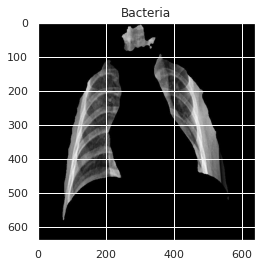

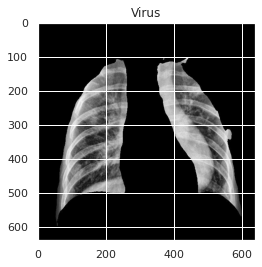

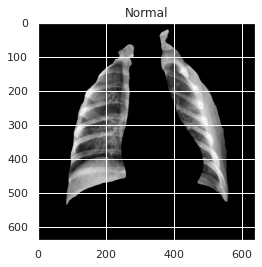

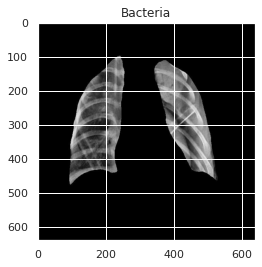

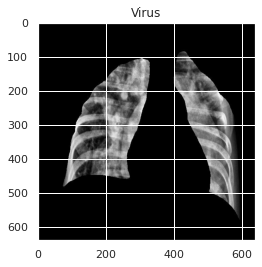

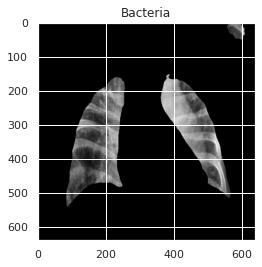

In [14]:
label_dict = {0:'Normal',1:'Virus',2:'Bacteria'}
for step,(x,y) in enumerate(train_dataloader):
  image = x[0].detach().numpy()
  label = y[0].detach().numpy()
  target = label.argmax()
  plt.imshow(image.reshape((image.shape[1],image.shape[2])),cmap='gray')
  plt.title(label_dict[int(target)])
  plt.show()
  if step==5:
    break

In [15]:
# Teste
test_image_paths = dados_df.loc[dados_df.Dataset_type == 'TEST','path'].values
test_labels = dados_df.loc[dados_df.Dataset_type == 'TEST',['Normal','Virus','bacteria']].values

test_dataset = lungClassify(test_image_paths,test_labels,transformer)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

# 4-) Modelo

In [16]:
class LungClassification(pl.LightningModule):
  def __init__(self):
    super().__init__()
    self.model = timm.create_model('resnet34',pretrained=True,num_classes=3,in_chans=1)

  def forward(self,image):
    return self.model(image)

  def shared_step(self,batch,stage):
    image,label = batch
    image = image.unsqueeze(0) 
    image = torch.reshape(image,[8, 1, width, height])
    
    y_hat = self.forward(image)
    probs = torch.nn.functional.softmax(y_hat,dim=1)
    
    label = label.float()
    loss = torch.nn.functional.cross_entropy(probs, label)
    
    return {'loss':loss,'probs':probs, 'label':label}

  def shared_epoch_end(self, outputs, stage):
    probs = torch.cat([x["probs"] for x in outputs])
    label = torch.cat([x["label"] for x in outputs])
    
    pred = torch.argmax(probs, dim=1)
    target = torch.argmax(label, dim=1)
    
    f1 = multiclass_f1_score(pred, target,num_classes=3)
    recall = multiclass_recall(pred, target,num_classes=3)
    precision = multiclass_precision(pred, target,num_classes=3)
    
    multi_roc = MulticlassAUROC(num_classes=3)
    AUCROC = multi_roc(probs, target)
    
    metrics = {
        f"{stage}_F1_SCORE": f1,
        f"{stage}_RECALL": recall,
        f"{stage}_PRECISION": precision,
        f"{stage}_AUCROC":AUCROC,
    }

    self.log_dict(metrics, prog_bar=True)
    
  def training_step(self, batch, batch_idx):
    return self.shared_step(batch, "train") 

  def validation_step(self, batch, batch_idx):
    return self.shared_step(batch, "valid")

  def validation_epoch_end(self, outputs):
    return self.shared_epoch_end(outputs, "valid")

  def predict_step(self, batch, batch_idx, dataloader_idx=None):
    return self(batch[0])
    
  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=0.0001)

In [ ]:
model = LungClassification().double()
trainer = pl.Trainer(accelerator='gpu', devices=1,max_epochs=5)

In [ ]:
trainer.fit(model, train_dataloaders=train_dataloader) 

In [ ]:
model_path = "/kaggle/working/" + "/Resnet_LungClassification"

In [ ]:
torch.save(model.state_dict(), model_path)

# 5-) Avaliação

In [17]:
model = LungClassification().double()
trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=5)
model.load_state_dict(torch.load("/kaggle/input/lungs-classification/Resnet_LungClassification"))

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/resnet34-43635321.pth" to /root/.cache/torch/hub/checkpoints/resnet34-43635321.pth


<All keys matched successfully>

In [18]:
valid_metrics = trainer.validate(model, dataloaders=val_dataloader, verbose=False)
print(valid_metrics)
predictions = trainer.predict(model, val_dataloader)

Validation: 0it [00:00, ?it/s]

[{'valid_F1_SCORE': 0.7909091114997864, 'valid_RECALL': 0.7909091114997864, 'valid_PRECISION': 0.7909091114997864, 'valid_AUCROC': 0.8957366943359375}]


Predicting: 0it [00:00, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.87      0.91       372
           1       0.56      0.68      0.62       291
           2       0.83      0.80      0.81       657

    accuracy                           0.79      1320
   macro avg       0.78      0.78      0.78      1320
weighted avg       0.81      0.79      0.80      1320



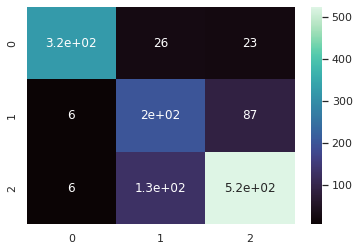

In [20]:
probs = torch.nn.functional.softmax(torch.cat(predictions),dim=1)
preds = torch.argmax(probs,dim=1).detach().numpy()
target = y_val.argmax(axis=1)
eval_df = pd.DataFrame({'pred':preds,'real':target})

print(classification_report(preds,target))
sns.heatmap(confusion_matrix(preds,target), annot=True,cmap="mako")
plt.show()

Insights: Alto erro na predição de pneumonia causada por virus, o modelo está confundindo com aquelas causadas por bacteria. Apesar disso, são poucos os casos onde o modelo prevê um paciente doente como saudável ( erro mais crítico para inferência médica )


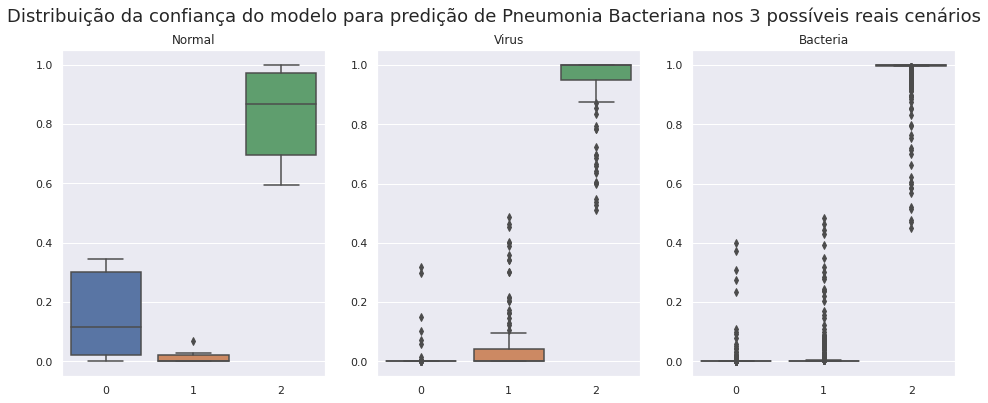

In [21]:
# Analisando a confiança do modelo dentro do universo de predições de Pneumonia por bacteria
labels_name = ['Normal','Virus','Bacteria']
fig,ax = plt.subplots(1,3,figsize=(16,6))
for i in range(3):
    caso = probs.detach().numpy()[(preds==2) & (target==i)]
    sns.boxplot(data = caso,ax=ax[i])
    ax[i].set_title(labels_name[i],fontsize=12)
plt.suptitle("Distribuição da confiança do modelo para predição de Pneumonia Bacteriana nos 3 possíveis reais cenários",fontsize=18)
plt.show()


Insights: Não é obervado maiores valores de probabilidades para o target '1' quando a condição do paciente é de pneumonia por Virus e o modelo preveu como bacteriana. 
Sabe-se que a diferença entre tais tipos de pneumonia é sutil e até dificil de indentificar por imagens de raio-x, suas diferenças consistem em:
* Por virus: Apresenta áreas de opacidade menos densas e mais difusas.
* Por bacterias: Apresenta áreas de opacidade mais densas e bem definidas e, pode conter, derrames pleurais ou linfonodos aumentados.

Logo, é necessário uma modificação nas imagens de entrada para o modelo capturar tais diferenças. ( aumento da resolução obteve êxito)

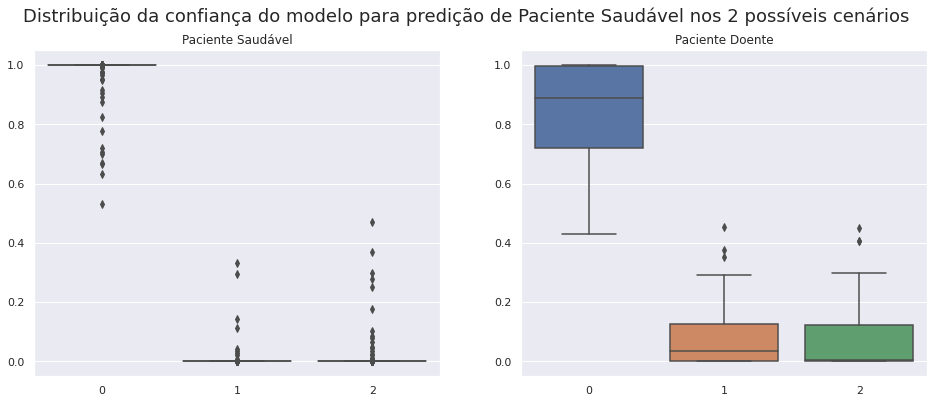

Teste de hipótese comparando as médias para as probabilidades da Pneumonia por virus


,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,-4.91643,48.824057,less,0.000005,"[-inf, -0.040812298606158225]",1.668106,2.078e+04,1.0


Teste de hipótese comparando as médias para as probabilidades da Pneumonia por Bactéria


,T,dof,alternative,p-val,CI99%,cohen-d,BF10,power
T-test,-3.641066,49.976617,less,0.000322,"[-inf, -0.021587182354396404]",1.057581,147.916,1.0


In [22]:
# Analisando a confiança do modelo dentro do universo de predições de paciente saudaveis, quando apresentam Pneumonia.
labels_name = ['Saudavel','Doente']
fig,ax = plt.subplots(1,2,figsize=(16,6))

saudavel = probs.detach().numpy()[(preds==0) & (target==0)]
doente = probs.detach().numpy()[(preds==0) & (target!=0)]
sns.boxplot(data = saudavel,ax=ax[0])
ax[0].set_title("Paciente Saudável",fontsize=12)
sns.boxplot(data = doente,ax=ax[1])
ax[1].set_title("Paciente Doente",fontsize=12)
plt.suptitle("Distribuição da confiança do modelo para predição de Paciente Saudável nos 2 possíveis cenários",fontsize=18)
plt.show()

print("Teste de hipótese comparando as médias para as probabilidades da Pneumonia por virus")
display(pg.ttest(saudavel[:,1],doente[:,1],alternative="less",confidence=0.99))
print("Teste de hipótese comparando as médias para as probabilidades da Pneumonia por Bactéria")
display(pg.ttest(saudavel[:,2],doente[:,2],alternative="less",confidence=0.99))

Insights: Pela análise estatística acima, percebe-se que em ambos os teste a hipotese nula foi rejeitada. Os casos nos quais o modelo prevê um paciente doente como saudável, apresenta probabilidades nos labels "1"(virus) e "2"(bacteria) significativamente acima daqueles que aparecem quando o paciente é normal. Logo, pode-se definir que para valores de tais probabilidades acima de 5%, a resposta do modelo pode ser  imediatamente conferida por um profissional humano.